In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [216]:
train = pd.read_csv("../../data/dacon_parking_demand_dataset/train.csv")
test = pd.read_csv("../../data/dacon_parking_demand_dataset/test.csv")
sub = pd.read_csv("../../data/dacon_parking_demand_dataset/test.csv")
age = pd.read_csv("../../data/dacon_parking_demand_dataset/age_gender_info.csv")
rent_deposit_gbm = pd.read_csv("predicted_rent_deposit_GBM_0728.csv")

In [217]:
train.shape, test.shape, rent_deposit_gbm.shape

((2952, 15), (1022, 14), (767, 2))

In [218]:
# 오류1번 트레인 셋 처리
# 총세대수와 전용면적별 세대수 합이 다른 단지코드의 값을 -> 전용면적별세대수의 합으로 수정하기

def house_number_correction(df):
    error_1_group = df.groupby("단지코드")[["총세대수"]]
    total_number_house_hold = error_1_group.mean()

    error_2_group = df.groupby("단지코드")["전용면적별세대수"]
    sum_house_hold = error_2_group.sum()

    check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
    different_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

    total_house_index = different_df.index
    total_house_number = []
    for v in different_df.values:
        total_house_number.append(v[1])
    
    for code, value in zip(total_house_index, total_house_number):
         df.loc[df["단지코드"] == code, "총세대수"] = value
    
    return df

train = house_number_correction(train)
test = house_number_correction(test)

In [219]:
error_1_group = train.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = train.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

print(check_df.shape)
check_df

(0, 2)


,총세대수,전용면적별세대수
단지코드,,


In [220]:
error_1_group = test.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = test.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

check_df.shape

(0, 2)

In [221]:
# 오류2번 3번 처리하기

train[(train["단지코드"] == "C2675") | (train["단지코드"] == "C2335") | (train["단지코드"] == "C1327")]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [222]:
test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
579,C2675,512,아파트,경기도,국민임대,36.65,130,9.0,A,18476000,154790,0.0,3.0,1016.0
580,C2675,512,아파트,경기도,국민임대,46.90,44,9.0,A,34082000,232200,0.0,3.0,1016.0
581,C2675,512,아파트,경기도,국민임대,46.90,80,9.0,A,34082000,232200,0.0,3.0,1016.0


In [223]:
# 테스트 데이터 셋에서 세개의 코드 데이터를 없애기 (2, 3번 3개 코드 제거)

error_index = test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].index
test = test.drop(index=error_index, axis=0)

In [224]:
# 에러2번의 5개 단지코드 트레인 셋 제거

train_set_error_index = train[(train["단지코드"] =="C2085") | (train["단지코드"] =="C1397") | (train["단지코드"] =="C2431") | (train["단지코드"] =="C1649") | (train["단지코드"] =="C1036")].index
train = train.drop(index=train_set_error_index, axis=0)

In [225]:
# 에러3번의 트레인 셋 7개 단지 코드 제거

train_set_error_index = train[(train["단지코드"] =="C1095") | (train["단지코드"] =="C2051") | (train["단지코드"] =="C1218") | (train["단지코드"] =="C1894") | (train["단지코드"] =="C2483") | (train["단지코드"] =="C1502") | (train["단지코드"] =="C1988")].index
train = train.drop(index=train_set_error_index, axis=0)

In [226]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [227]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [228]:
# 임대보증금 피처 전처리
# 임대보증금이 0인 행의 데이터를 -> 트레인 셋의 지역별 평균 값으로 치환
train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)

In [229]:
train_df.index

Int64Index([   8,    9,   10,   11,   12,   13,   14,   15,   16,   17,
            ...
            2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951],
           dtype='int64', length=2869)

In [230]:
test_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021],
           dtype='int64', length=1008)

In [231]:
train_df[train_df["임대보증금"] == 0].index

Int64Index([  88,   89,   90,   91,  101,  102,  103,  104,  105,  106,
            ...
            2549, 2550, 2551, 2680, 2681, 2682, 2683, 2906, 2907, 2908],
           dtype='int64', length=581)

In [232]:
test_df[test_df["임대보증금"] == 0].index

Int64Index([  76,   77,   79,   80,   81,   82,   83,   84,   85,   86,
            ...
             329,  330,  331,  332, 1005, 1006, 1014, 1015, 1016, 1017],
           dtype='int64', length=186)

In [233]:
rent_deposit_gbm.iloc[581]

index    7.600000e+01
임대보증금    1.134360e+07
Name: 581, dtype: float64

In [234]:
train_rent_deposit_gbm = rent_deposit_gbm.iloc[:581]
test_rent_deposit_gbm = rent_deposit_gbm.iloc[581:]

In [235]:
train_rent_deposit_gbm = train_rent_deposit_gbm.set_index("index")
test_rent_deposit_gbm = test_rent_deposit_gbm.set_index("index")

In [236]:
train_df.loc[train_rent_deposit_gbm.index, "임대보증금"] = train_rent_deposit_gbm["임대보증금"]
test_df.loc[test_rent_deposit_gbm.index, "임대보증금"] = test_rent_deposit_gbm["임대보증금"]

In [237]:
train_df[train_df["임대보증금"] == 0]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
576,C1439,1755,상가,부산광역시,임대상가,16.57,1,29.0,D,0.0,NaN,1.0,3.0,270.0,172.0
577,C1439,1755,상가,부산광역시,임대상가,16.57,1,29.0,D,0.0,NaN,1.0,3.0,270.0,172.0
786,C1875,1003,상가,충청남도,임대상가,14.10,1,5.0,D,0.0,NaN,NaN,8.0,192.0,209.0


In [238]:
test_df[test_df["임대보증금"] == 0]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
120,C2676,2572,상가,부산광역시,임대상가,16.57,1,25.0,D,0.0,NaN,0.0,2.0,418.0


In [239]:
train_df["임대보증금"].isnull().sum()

0

In [240]:
test_df["임대보증금"].isnull().sum()

0

<AxesSubplot:>

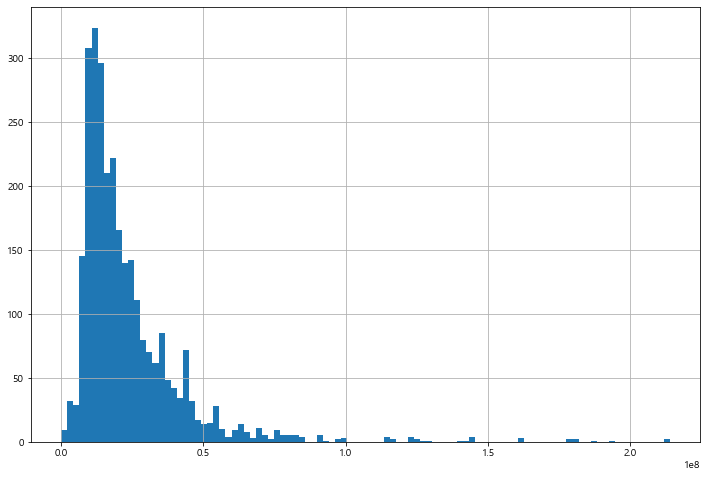

In [241]:
train_df["임대보증금"].hist(bins=100, figsize=(12, 8))

In [242]:
train_df["임대보증금"].value_counts()

2.477500e+07    22
1.441800e+07    21
5.787000e+06    18
1.872600e+07    17
4.300000e+07    17
                ..
3.807700e+07     1
8.133000e+06     1
1.126900e+07     1
1.209146e+07     1
1.588400e+07     1
Name: 임대보증금, Length: 1160, dtype: int64

In [243]:
train_df["임대보증금"].skew()

3.712054826461096

In [244]:
train_df["임대보증금"].kurt()

21.69614839463322

In [245]:
# 레이블 인코딩인데, 원핫 인코딩으로 바꿔보기

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [246]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [247]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

In [248]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [249]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [250]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

<AxesSubplot:>

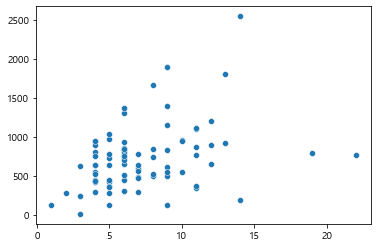

In [251]:
area_group = train_df.groupby("지역")["등록차량수"]

values = area_group.get_group("경기도").value_counts().index
counts = area_group.get_group("경기도").value_counts().values

sns.scatterplot(x=counts, y=values)

In [252]:
# 지역별 인구수 컬럼 추가

# population_df = pd.read_csv("../data/dacon_parking_demand_dataset/age_gender_info.csv")
# partial_population_df = population_df[["20대(남자)", "40대(남자)", "50대(여자)", "지역"]]
# train_df = pd.merge(train_df, partial_population_df, on="지역")
# test_df = pd.merge(test_df, partial_population_df, on="지역")

# train_df.columns

In [253]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [254]:
train_df[train_df["단지코드"] == "C1039"]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,대구광역시,대전광역시,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000.0,...,0,0,0,0,0,0,0,0,0,0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2103,C1039,790,아파트,서울특별시,국민임대,26.68,26,13.0,A,15282000.0,...,0,0,0,0,0,0,0,0,0,0
2104,C1039,790,아파트,서울특별시,국민임대,36.70,140,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2105,C1039,790,아파트,서울특별시,국민임대,36.70,14,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2106,C1039,790,아파트,서울특별시,국민임대,36.87,43,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2107,C1039,790,아파트,서울특별시,국민임대,46.76,192,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2108,C1039,790,아파트,서울특별시,국민임대,46.96,25,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2109,C1039,790,아파트,서울특별시,영구임대,26.68,70,13.0,I,11490000.0,...,0,0,0,0,0,0,0,0,0,0


In [255]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [256]:
# 전용 면적 피처를 5의 배수로 전처리, 전후로 비교해서 (103.69 -> 102.80까지 떨어짐)
train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [257]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [258]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [259]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [260]:
train_df["공급유형"].value_counts()

국민임대         1727
임대상가          562
행복주택          202
공공임대(10년)     175
영구임대          152
공공임대(50년)      31
공공임대(분납)        7
공공분양            7
공공임대(5년)        3
장기전세            3
Name: 공급유형, dtype: int64

In [261]:
train_df[train_df["공급유형"] == "장기전세"]

,단지코드,총세대수,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,...,전라남도,전라북도,제주특별자치도,충청남도,충청북도,상가,아파트,세대수 규모 당 총 전용면적,단지별 총 전용면적,전용면적 당 차량등록수
2100,C1039,790,서울특별시,장기전세,50.0,126,13.0,A,187694000.0,-,...,0,0,0,0,0,0,1,6300.0,33080.0,122.838573
2101,C1039,790,서울특별시,장기전세,55.0,49,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,2695.0,33080.0,52.547612
2102,C1039,790,서울특별시,장기전세,55.0,75,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,4125.0,33080.0,80.430018


In [262]:
test_df["공급유형"].value_counts() # 테스트 셋에는 없는 공급유형 -> 공공분양, 공공임대(5년), 장기전세

국민임대         614
임대상가         177
행복주택         120
영구임대          43
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64

In [263]:
supply_qualification_df = pd.get_dummies(train_df["공급유형"])
train_df = pd.concat([train_df, supply_qualification_df], axis=1)

supply_qualification_df = pd.get_dummies(test_df["공급유형"])
test_df = pd.concat([test_df, supply_qualification_df], axis=1)
test_df["공공임대(5년)"] = 0
test_df["공공분양"] = 0
test_df["장기전세"] = 0

In [264]:
train_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도',
       '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도',
       '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적',
       '단지별 총 전용면적', '전용면적 당 차량등록수', '공공분양', '공공임대(10년)', '공공임대(50년)',
       '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [265]:
test_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'B', 'F', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적',
       '공공임대(10년)', '공공임대(50년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '행복주택',
       '공공임대(5년)', '공공분양', '장기전세'],
      dtype='object')

In [266]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   지역                            2869 non-null   object 
 3   공급유형                          2869 non-null   object 
 4   전용면적                          2869 non-null   float64
 5   전용면적별세대수                      2869 non-null   int64  
 6   공가수                           2869 non-null   float64
 7   자격유형                          2869 non-null   object 
 8   임대보증금                         2869 non-null   float64
 9   임대료                           2300 non-null   object 
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 12  단지내주차면수                       2869 non-null   float64
 13  등록차

### 전처리한 피처들의 선형성 검증 이변량 분석

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

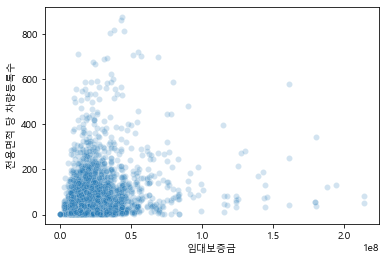

In [267]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='전용면적 당 차량등록수'>

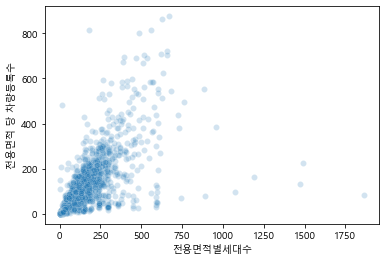

In [268]:
sns.scatterplot(data=train_df, x="전용면적별세대수", y="전용면적 당 차량등록수", alpha=0.2)

In [269]:
# 503, 1871, 1951, 1977, 2023

outlier_index = train_df[train_df["전용면적별세대수"] >= 1000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [270]:
outlier_index = train_df[(train_df["전용면적별세대수"] <= 30) & (train_df["전용면적 당 차량등록수"] >=400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [271]:
# 301 아웃라이어 제거

train_df[(train_df["전용면적별세대수"] > 150) & (train_df["전용면적 당 차량등록수"] > 750)]

train_df = train_df.drop(index=301, axis=0)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='Count'>

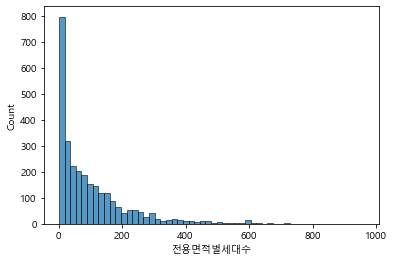

In [272]:
sns.histplot(train_df["전용면적별세대수"])

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='전용면적 당 차량등록수'>

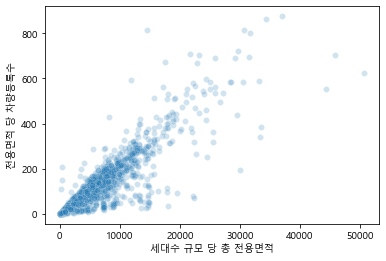

In [273]:
sns.scatterplot(data=train_df, x="세대수 규모 당 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

In [274]:
# 1974, 2141, 2532

outlier_index = train_df[train_df["세대수 규모 당 총 전용면적"] > 40000].index

train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='Count'>

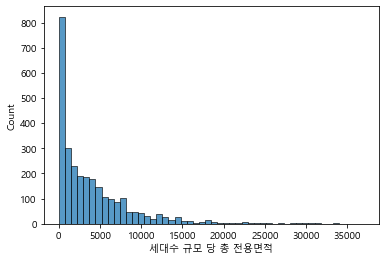

In [275]:
sns.histplot(train_df["세대수 규모 당 총 전용면적"])

<AxesSubplot:xlabel='실거주세대수', ylabel='전용면적 당 차량등록수'>

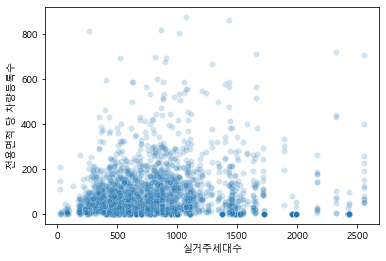

In [276]:
sns.scatterplot(data=train_df, x="실거주세대수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='실거주세대수', ylabel='Count'>

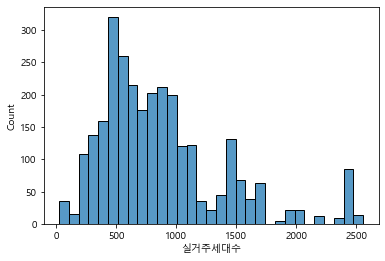

In [277]:
sns.histplot(train_df["실거주세대수"])

<AxesSubplot:xlabel='단지별 총 전용면적', ylabel='전용면적 당 차량등록수'>

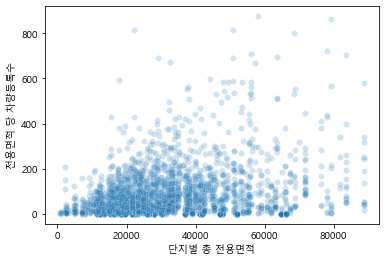

In [278]:
sns.scatterplot(data=train_df, x="단지별 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='단지별 총 전용면적', ylabel='Count'>

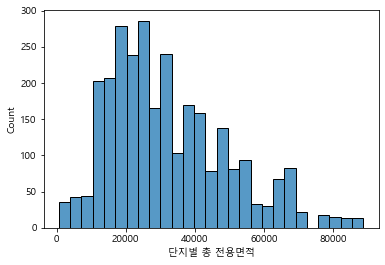

In [279]:
sns.histplot(train_df["단지별 총 전용면적"])

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

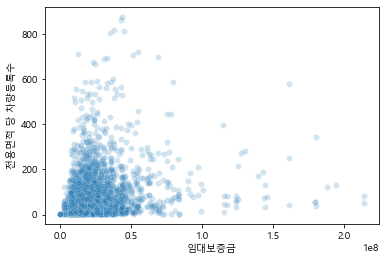

In [280]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

In [281]:
# 임대보증금 아웃라이어 2111, 2812, 2813, 2814 제거

outlier_index = train_df[train_df["임대보증금"] >= 187694000].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='도보 10분거리 내 버스정류장 수', ylabel='전용면적 당 차량등록수'>

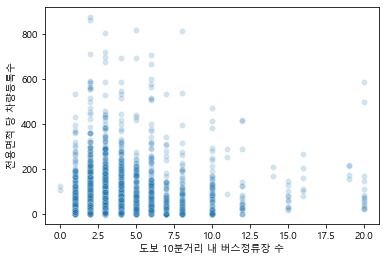

In [282]:
sns.scatterplot(data=train_df, x="도보 10분거리 내 버스정류장 수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='도보 10분거리 내 버스정류장 수', ylabel='Count'>

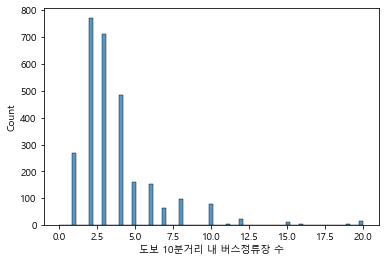

In [283]:
sns.histplot(train_df["도보 10분거리 내 버스정류장 수"])

<AxesSubplot:xlabel='도보 10분거리 내 지하철역 수(환승노선 수 반영)', ylabel='전용면적 당 차량등록수'>

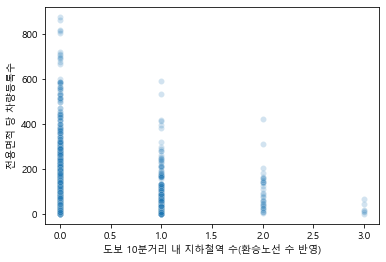

In [284]:
sns.scatterplot(data=train_df, x="도보 10분거리 내 지하철역 수(환승노선 수 반영)", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='도보 10분거리 내 지하철역 수(환승노선 수 반영)', ylabel='Count'>

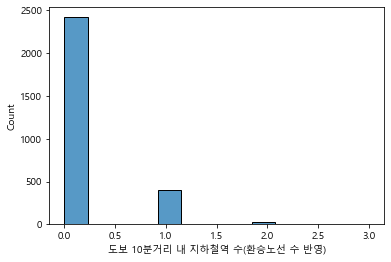

In [285]:
sns.histplot(train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"])

<AxesSubplot:xlabel='상가', ylabel='전용면적 당 차량등록수'>

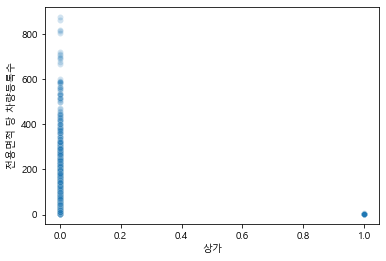

In [286]:
sns.scatterplot(data=train_df, x="상가", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

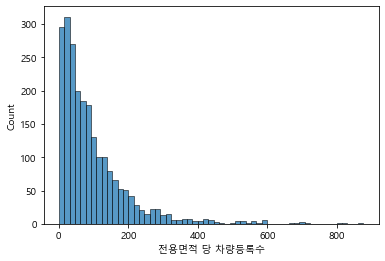

In [287]:
sns.histplot(train_df[train_df["상가"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

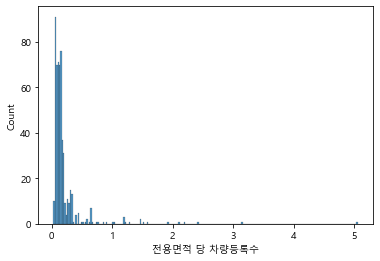

In [288]:
sns.histplot(train_df[train_df["상가"] == 1]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

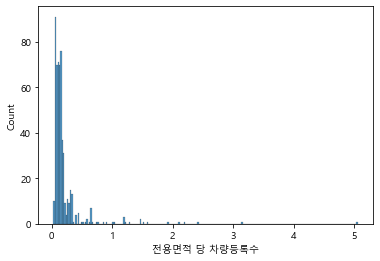

In [289]:
sns.histplot(train_df[train_df["아파트"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

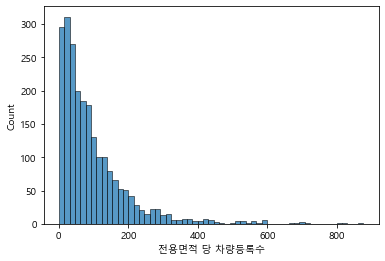

In [290]:
sns.histplot(train_df[train_df["아파트"] == 1]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

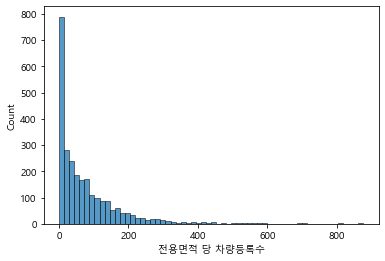

In [291]:
sns.histplot(train_df[train_df["강원도"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='자격유형', ylabel='전용면적 당 차량등록수'>

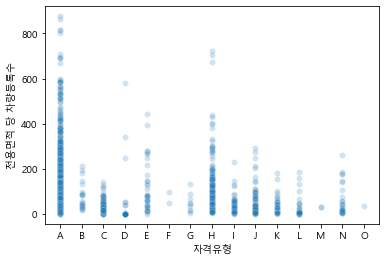

In [292]:
sns.scatterplot(data=train_df, x="자격유형", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='지역', ylabel='전용면적 당 차량등록수'>

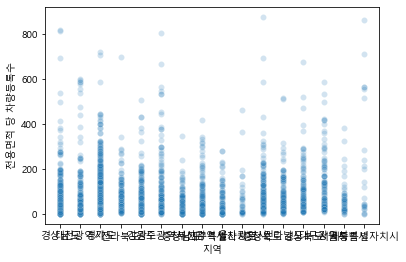

In [293]:
sns.scatterplot(data=train_df, x="지역", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='세대수비율주차면수', ylabel='전용면적 당 차량등록수'>

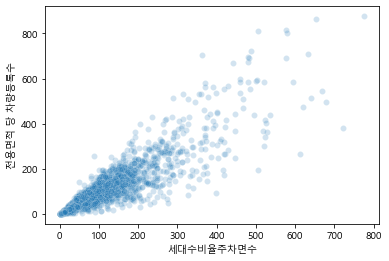

In [294]:
sns.scatterplot(data=train_df, x="세대수비율주차면수", y="전용면적 당 차량등록수", alpha=0.2)

In [295]:
# 세대수비율주차면수 아웃라이어 제거 314

outlier_index = train_df[(train_df["세대수비율주차면수"] >= 700) & (train_df["전용면적 당 차량등록수"] < 400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [296]:
correlation_df = train_df.corr().sort_values(by="전용면적 당 차량등록수", ascending=False)

# plt.figure(figsize=(20, 16))
# sns.heatmap(correlation_df, annot=True, fmt=".4f", cmap='YlGnBu')

In [297]:
correlation_df

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,A,...,공공분양,공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,임대상가,장기전세,행복주택
전용면적 당 차량등록수,-0.008533,0.086054,0.789069,0.121870,0.227638,-0.084184,0.070765,0.384005,0.493973,0.332329,...,0.053883,0.266957,0.017333,0.066608,0.022382,0.250349,-0.088255,-0.375536,NaN,-0.096768
세대수비율주차면수,0.027472,0.021849,0.898431,0.239892,0.140693,-0.085429,0.064952,0.442654,0.415033,0.310859,...,0.017160,0.167297,0.013636,0.055847,0.011636,0.297702,-0.050803,-0.408829,NaN,-0.063255
세대수 규모 당 총 전용면적,0.016870,0.068713,0.925335,0.141603,0.168081,-0.076317,0.072934,0.344077,0.367491,0.302032,...,0.034181,0.203279,0.075896,0.012340,0.010665,0.232106,0.062740,-0.402512,NaN,-0.101567
전용면적별세대수,0.062013,-0.030675,1.000000,0.185720,0.040573,-0.075917,0.064737,0.323313,0.296089,0.195018,...,0.000841,0.054284,0.087283,0.009768,-0.007566,0.218229,0.195092,-0.410776,NaN,-0.032354
등록차량수,0.327042,0.096542,0.296089,0.129783,0.421233,-0.077352,0.111463,0.857204,1.000000,0.346411,...,0.203075,0.390067,-0.059064,0.025368,0.084339,0.263739,-0.089065,-0.449912,NaN,-0.125648
단지내주차면수,0.521607,0.052993,0.323313,0.302376,0.350122,-0.026177,0.079991,1.000000,0.857204,0.263348,...,0.132360,0.230656,-0.075575,0.014964,0.047712,0.288324,-0.083749,-0.409617,NaN,-0.063084
아파트,-0.345064,-0.015352,0.410776,0.249805,0.289874,-0.158689,0.013776,0.409617,0.449912,0.610290,...,0.024554,0.125399,0.051037,0.016063,0.024554,0.611632,0.115392,-1.000000,NaN,0.136663
A,-0.339916,0.118514,0.195018,0.007473,0.089864,-0.096454,0.011556,0.263348,0.346411,1.000000,...,-0.061113,0.205475,0.083628,0.026320,0.040233,0.684438,-0.280724,-0.610290,NaN,-0.340145
공공임대(10년),-0.032233,0.188488,0.054284,-0.066621,0.364168,-0.048931,0.001646,0.230656,0.390067,0.205475,...,-0.012557,1.000000,-0.026101,-0.008215,-0.012557,-0.312798,-0.059013,-0.125399,NaN,-0.069891
국민임대,-0.255778,0.007655,0.218229,0.144856,0.001151,-0.099070,0.018739,0.288324,0.263739,0.684438,...,-0.061247,-0.312798,-0.127309,-0.040067,-0.061247,1.000000,-0.287835,-0.611632,NaN,-0.340893


In [298]:
# X_train & X_test 셋 선택

# ["상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
#  "전용면적 당 차량등록수", "총세대수"]

X_train_df_sel = train_df.drop(["단지코드", "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "전용면적 당 차량등록수", "총세대수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "상가", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "총세대수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [299]:
X_train_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [300]:
column_names = ['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [301]:
X_train_df_sel

,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,E,...,공공분양,공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,임대상가,장기전세,행복주택
8,276,17.0,9216000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,60,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,20,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11,38,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12,19,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,19,7.0,11346000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2948,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2949,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2950,114,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [302]:
X_train_df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2854 entries, 8 to 2951
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   전용면적별세대수                      2854 non-null   int64  
 1   공가수                           2854 non-null   float64
 2   임대보증금                         2854 non-null   float64
 3   도보 10분거리 내 지하철역 수(환승노선 수 반영)  2854 non-null   float64
 4   도보 10분거리 내 버스정류장 수            2854 non-null   float64
 5   A                             2854 non-null   uint8  
 6   B                             2854 non-null   uint8  
 7   C                             2854 non-null   uint8  
 8   D                             2854 non-null   uint8  
 9   E                             2854 non-null   uint8  
 10  F                             2854 non-null   uint8  
 11  G                             2854 non-null   uint8  
 12  H                             2854 non-null   uint8  
 13  I  

In [303]:
X_train_df_log = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_log = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df_log = y_train_df.apply(lambda x: np.log1p(x))

### Linear Regression 모델 평가

In [304]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor

In [305]:
X_train_df_log.shape, X_test_df_log.shape, y_train_df_log.shape

((2854, 48), (1008, 48), (2854,))

In [306]:
params = {"alpha": [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
ridge_model = Ridge()

grid_model = GridSearchCV(ridge_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_model.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1,
                                   1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40,
                                   50]},
             scoring='neg_mean_absolute_error')

In [307]:
grid_model.best_params_

{'alpha': 40}

In [308]:
best_ridge = grid_model.best_estimator_
best_ridge

Ridge(alpha=40)

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = best_ridge.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

15.17497611520812

In [168]:
# # 릿지 모델 예측

# ridge_model = Ridge(alpha=30)
# ridge_model.fit(X_train_df_log, y_train_df_log)
# pred = ridge_model.predict(X_test_df_log)
# pred = np.expm1(pred)

# result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
# result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

# pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
# final_pred = pd.Series(pred_group)
# final_pred = final_pred.reset_index(drop=False)

# sub_df = sub.merge(final_pred, how="left")
# sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
# sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
# sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# # sub_df.to_csv("ridge_with_이상치처리_다중공선성피처제거_0722.csv", index=False)

# sub_df

,code,num
0,C1072,695.774506
1,C1128,1185.740972
2,C1456,547.213972
3,C1840,491.149263
4,C1332,1130.762908
...,...,...
145,C2456,232.423730
146,C1266,422.569213
147,C2152,28.756858
148,C1267,335.554013


In [310]:
# importance = ridge_model.coef_
# feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
# feature_importance = feature_importance.sort_values(ascending=False)

# plt.figure(figsize=(20, 12))
# sns.barplot(x=feature_importance, y=feature_importance.index)
# plt.show()

AttributeError: 'Ridge' object has no attribute 'coef_'

In [170]:
cat_reg = CatBoostRegressor()

cat_reg.fit(X_train, y_train)
pred = cat_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

Learning rate set to 0.04469
0:	learn: 1.7666323	total: 146ms	remaining: 2m 26s
1:	learn: 1.6949588	total: 148ms	remaining: 1m 13s
2:	learn: 1.6282127	total: 149ms	remaining: 49.6s
3:	learn: 1.5617337	total: 151ms	remaining: 37.5s
4:	learn: 1.5006612	total: 151ms	remaining: 30.1s
5:	learn: 1.4393472	total: 153ms	remaining: 25.3s
6:	learn: 1.3816965	total: 154ms	remaining: 21.8s
7:	learn: 1.3295461	total: 155ms	remaining: 19.2s
8:	learn: 1.2757298	total: 156ms	remaining: 17.2s
9:	learn: 1.2260460	total: 157ms	remaining: 15.6s
10:	learn: 1.1799607	total: 159ms	remaining: 14.3s
11:	learn: 1.1340970	total: 160ms	remaining: 13.2s
12:	learn: 1.0905202	total: 161ms	remaining: 12.2s
13:	learn: 1.0480217	total: 162ms	remaining: 11.4s
14:	learn: 1.0092599	total: 163ms	remaining: 10.7s
15:	learn: 0.9705941	total: 164ms	remaining: 10.1s
16:	learn: 0.9348442	total: 165ms	remaining: 9.54s
17:	learn: 0.8998656	total: 166ms	remaining: 9.06s
18:	learn: 0.8689824	total: 167ms	remaining: 8.64s
19:	learn:

168:	learn: 0.2115192	total: 347ms	remaining: 1.71s
169:	learn: 0.2109973	total: 348ms	remaining: 1.7s
170:	learn: 0.2104804	total: 349ms	remaining: 1.69s
171:	learn: 0.2102030	total: 350ms	remaining: 1.69s
172:	learn: 0.2099043	total: 352ms	remaining: 1.68s
173:	learn: 0.2096131	total: 353ms	remaining: 1.68s
174:	learn: 0.2092061	total: 354ms	remaining: 1.67s
175:	learn: 0.2086004	total: 355ms	remaining: 1.66s
176:	learn: 0.2083158	total: 357ms	remaining: 1.66s
177:	learn: 0.2080350	total: 358ms	remaining: 1.65s
178:	learn: 0.2078849	total: 359ms	remaining: 1.65s
179:	learn: 0.2077127	total: 360ms	remaining: 1.64s
180:	learn: 0.2073466	total: 361ms	remaining: 1.64s
181:	learn: 0.2067848	total: 363ms	remaining: 1.63s
182:	learn: 0.2062596	total: 364ms	remaining: 1.62s
183:	learn: 0.2059469	total: 365ms	remaining: 1.62s
184:	learn: 0.2057232	total: 366ms	remaining: 1.61s
185:	learn: 0.2054553	total: 368ms	remaining: 1.61s
186:	learn: 0.2050809	total: 369ms	remaining: 1.6s
187:	learn: 0.

449:	learn: 0.1523537	total: 683ms	remaining: 835ms
450:	learn: 0.1522048	total: 684ms	remaining: 833ms
451:	learn: 0.1518374	total: 686ms	remaining: 831ms
452:	learn: 0.1518005	total: 687ms	remaining: 829ms
453:	learn: 0.1517078	total: 688ms	remaining: 827ms
454:	learn: 0.1516088	total: 689ms	remaining: 826ms
455:	learn: 0.1515407	total: 690ms	remaining: 824ms
456:	learn: 0.1514750	total: 692ms	remaining: 822ms
457:	learn: 0.1513194	total: 693ms	remaining: 820ms
458:	learn: 0.1512548	total: 694ms	remaining: 818ms
459:	learn: 0.1509717	total: 695ms	remaining: 816ms
460:	learn: 0.1509068	total: 697ms	remaining: 814ms
461:	learn: 0.1507675	total: 698ms	remaining: 813ms
462:	learn: 0.1505854	total: 699ms	remaining: 811ms
463:	learn: 0.1505220	total: 700ms	remaining: 809ms
464:	learn: 0.1503506	total: 701ms	remaining: 807ms
465:	learn: 0.1502429	total: 702ms	remaining: 805ms
466:	learn: 0.1500350	total: 704ms	remaining: 803ms
467:	learn: 0.1499012	total: 705ms	remaining: 801ms
468:	learn: 

724:	learn: 0.1193637	total: 1.02s	remaining: 386ms
725:	learn: 0.1192913	total: 1.02s	remaining: 385ms
726:	learn: 0.1191042	total: 1.02s	remaining: 383ms
727:	learn: 0.1189636	total: 1.02s	remaining: 382ms
728:	learn: 0.1188606	total: 1.02s	remaining: 381ms
729:	learn: 0.1187526	total: 1.02s	remaining: 379ms
730:	learn: 0.1185678	total: 1.03s	remaining: 378ms
731:	learn: 0.1184805	total: 1.03s	remaining: 376ms
732:	learn: 0.1184051	total: 1.03s	remaining: 375ms
733:	learn: 0.1183987	total: 1.03s	remaining: 373ms
734:	learn: 0.1182706	total: 1.03s	remaining: 372ms
735:	learn: 0.1182508	total: 1.03s	remaining: 370ms
736:	learn: 0.1180915	total: 1.03s	remaining: 369ms
737:	learn: 0.1179448	total: 1.03s	remaining: 367ms
738:	learn: 0.1178803	total: 1.04s	remaining: 366ms
739:	learn: 0.1177792	total: 1.04s	remaining: 364ms
740:	learn: 0.1176839	total: 1.04s	remaining: 363ms
741:	learn: 0.1175570	total: 1.04s	remaining: 362ms
742:	learn: 0.1174535	total: 1.04s	remaining: 360ms
743:	learn: 

9.38574738025158

In [171]:
# 릿지 0.5 & LGBM 0.5 조합 -> 12.3456 Score: 93.5424 (인구데이터 추가)
# 릿지 1.0 -> 14.9751 Score: 95.6543 (인구데이터 X)

# 릿지 0.9 & CatBoost 0.1 조합 -> 14.18295
# 릿지 0.8 & CatBoost 0.2 조합 -> 13.4380
# 릿지 0.7 & CatBoost 0.3 조합 -> 12.7728
# 릿지 0.6 & CatBoost 0.4 조합 -> 12.1470
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6074

# 릿지 alpha=50, 값으로 예측!!! 결과
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6044
# 릿지 0.4 & CatBoost 0.6 조합 -> 11.0139
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.5106

# 릿지 alpha=40,값으로 예측!! 결과
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.4283
# 릿지 0.4 & CatBoost 0.6 조합 -> 10.9511

ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

final_pred = (ridge_pred * 0.4) + (cat_pred * 0.6)
mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

Learning rate set to 0.04469
0:	learn: 1.7660153	total: 1.72ms	remaining: 1.71s
1:	learn: 1.6939579	total: 3.14ms	remaining: 1.56s
2:	learn: 1.6270559	total: 4.51ms	remaining: 1.5s
3:	learn: 1.5630121	total: 5.95ms	remaining: 1.48s
4:	learn: 1.4996392	total: 7.28ms	remaining: 1.45s
5:	learn: 1.4397555	total: 8.74ms	remaining: 1.45s
6:	learn: 1.3823125	total: 10.1ms	remaining: 1.43s
7:	learn: 1.3266946	total: 11.4ms	remaining: 1.41s
8:	learn: 1.2751619	total: 12.8ms	remaining: 1.41s
9:	learn: 1.2257300	total: 14.3ms	remaining: 1.42s
10:	learn: 1.1793590	total: 15.8ms	remaining: 1.42s
11:	learn: 1.1361100	total: 17.1ms	remaining: 1.41s
12:	learn: 1.0919931	total: 18.6ms	remaining: 1.41s
13:	learn: 1.0510757	total: 20ms	remaining: 1.41s
14:	learn: 1.0102971	total: 21.4ms	remaining: 1.41s
15:	learn: 0.9712882	total: 22.8ms	remaining: 1.4s
16:	learn: 0.9344677	total: 24.1ms	remaining: 1.39s
17:	learn: 0.8992607	total: 25.6ms	remaining: 1.39s
18:	learn: 0.8657534	total: 26.9ms	remaining: 1.3

262:	learn: 0.1873116	total: 329ms	remaining: 922ms
263:	learn: 0.1872371	total: 330ms	remaining: 920ms
264:	learn: 0.1869387	total: 331ms	remaining: 919ms
265:	learn: 0.1867858	total: 333ms	remaining: 918ms
266:	learn: 0.1866297	total: 334ms	remaining: 916ms
267:	learn: 0.1865642	total: 335ms	remaining: 915ms
268:	learn: 0.1863405	total: 336ms	remaining: 913ms
269:	learn: 0.1860509	total: 337ms	remaining: 912ms
270:	learn: 0.1856333	total: 339ms	remaining: 911ms
271:	learn: 0.1855036	total: 340ms	remaining: 909ms
272:	learn: 0.1852628	total: 341ms	remaining: 908ms
273:	learn: 0.1846514	total: 342ms	remaining: 907ms
274:	learn: 0.1845527	total: 343ms	remaining: 905ms
275:	learn: 0.1843196	total: 345ms	remaining: 904ms
276:	learn: 0.1841035	total: 346ms	remaining: 903ms
277:	learn: 0.1838454	total: 347ms	remaining: 901ms
278:	learn: 0.1836143	total: 348ms	remaining: 900ms
279:	learn: 0.1833478	total: 349ms	remaining: 899ms
280:	learn: 0.1830930	total: 351ms	remaining: 897ms
281:	learn: 

544:	learn: 0.1403290	total: 667ms	remaining: 556ms
545:	learn: 0.1403105	total: 668ms	remaining: 555ms
546:	learn: 0.1402529	total: 669ms	remaining: 554ms
547:	learn: 0.1400588	total: 670ms	remaining: 553ms
548:	learn: 0.1399227	total: 671ms	remaining: 552ms
549:	learn: 0.1398252	total: 673ms	remaining: 550ms
550:	learn: 0.1396918	total: 674ms	remaining: 549ms
551:	learn: 0.1395789	total: 675ms	remaining: 548ms
552:	learn: 0.1394690	total: 677ms	remaining: 547ms
553:	learn: 0.1394071	total: 678ms	remaining: 546ms
554:	learn: 0.1393287	total: 679ms	remaining: 544ms
555:	learn: 0.1391386	total: 680ms	remaining: 543ms
556:	learn: 0.1389478	total: 682ms	remaining: 542ms
557:	learn: 0.1386917	total: 683ms	remaining: 541ms
558:	learn: 0.1385474	total: 684ms	remaining: 540ms
559:	learn: 0.1384166	total: 686ms	remaining: 539ms
560:	learn: 0.1383471	total: 687ms	remaining: 538ms
561:	learn: 0.1380937	total: 688ms	remaining: 536ms
562:	learn: 0.1380228	total: 689ms	remaining: 535ms
563:	learn: 

818:	learn: 0.1108918	total: 1s	remaining: 222ms
819:	learn: 0.1107245	total: 1s	remaining: 220ms
820:	learn: 0.1106173	total: 1s	remaining: 219ms
821:	learn: 0.1104850	total: 1.01s	remaining: 218ms
822:	learn: 0.1103709	total: 1.01s	remaining: 217ms
823:	learn: 0.1102893	total: 1.01s	remaining: 216ms
824:	learn: 0.1101746	total: 1.01s	remaining: 214ms
825:	learn: 0.1101298	total: 1.01s	remaining: 213ms
826:	learn: 0.1100649	total: 1.01s	remaining: 212ms
827:	learn: 0.1098972	total: 1.01s	remaining: 211ms
828:	learn: 0.1097334	total: 1.01s	remaining: 209ms
829:	learn: 0.1096426	total: 1.02s	remaining: 208ms
830:	learn: 0.1095732	total: 1.02s	remaining: 207ms
831:	learn: 0.1094897	total: 1.02s	remaining: 206ms
832:	learn: 0.1093902	total: 1.02s	remaining: 205ms
833:	learn: 0.1093124	total: 1.02s	remaining: 203ms
834:	learn: 0.1092444	total: 1.02s	remaining: 202ms
835:	learn: 0.1091433	total: 1.02s	remaining: 201ms
836:	learn: 0.1090467	total: 1.02s	remaining: 200ms
837:	learn: 0.1089729

10.85041075585427

In [172]:
# 릿지 (alpha=40) 0.4 & CatBoost 0.6 조합 -> 88.6317475529 , MAE -> 10.9511
# 릿지 (alpha=40) 0.3 & CatBoost 0.7 조합 -> 89.9021750236, MAE -> 10.4283

ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

final_pred = (ridge_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge(0.4)&catboost(0.6)조합_공급유형추가_임대보증금지역예측값적용_0727.csv", index=False)

sub_df

Learning rate set to 0.04704
0:	learn: 1.7676638	total: 1.77ms	remaining: 1.76s
1:	learn: 1.6932903	total: 3.59ms	remaining: 1.79s
2:	learn: 1.6217559	total: 5.04ms	remaining: 1.68s
3:	learn: 1.5530860	total: 6.73ms	remaining: 1.68s
4:	learn: 1.4871545	total: 8.38ms	remaining: 1.67s
5:	learn: 1.4250644	total: 9.86ms	remaining: 1.63s
6:	learn: 1.3651551	total: 11.4ms	remaining: 1.61s
7:	learn: 1.3099859	total: 12.2ms	remaining: 1.51s
8:	learn: 1.2567135	total: 13.9ms	remaining: 1.53s
9:	learn: 1.2053241	total: 15.7ms	remaining: 1.55s
10:	learn: 1.1561144	total: 17.2ms	remaining: 1.55s
11:	learn: 1.1085535	total: 18.7ms	remaining: 1.54s
12:	learn: 1.0651810	total: 19.8ms	remaining: 1.5s
13:	learn: 1.0230843	total: 21.2ms	remaining: 1.49s
14:	learn: 0.9826531	total: 22.7ms	remaining: 1.49s
15:	learn: 0.9440812	total: 24.1ms	remaining: 1.48s
16:	learn: 0.9082635	total: 25.5ms	remaining: 1.47s
17:	learn: 0.8740238	total: 26.9ms	remaining: 1.47s
18:	learn: 0.8399272	total: 28.2ms	remaining: 

251:	learn: 0.1929951	total: 333ms	remaining: 988ms
252:	learn: 0.1926282	total: 334ms	remaining: 987ms
253:	learn: 0.1923566	total: 336ms	remaining: 986ms
254:	learn: 0.1920669	total: 337ms	remaining: 984ms
255:	learn: 0.1917676	total: 338ms	remaining: 983ms
256:	learn: 0.1915919	total: 340ms	remaining: 982ms
257:	learn: 0.1912678	total: 341ms	remaining: 981ms
258:	learn: 0.1909903	total: 342ms	remaining: 980ms
259:	learn: 0.1907253	total: 344ms	remaining: 978ms
260:	learn: 0.1903731	total: 345ms	remaining: 977ms
261:	learn: 0.1900949	total: 347ms	remaining: 976ms
262:	learn: 0.1897161	total: 348ms	remaining: 975ms
263:	learn: 0.1894424	total: 349ms	remaining: 973ms
264:	learn: 0.1891493	total: 350ms	remaining: 972ms
265:	learn: 0.1889733	total: 352ms	remaining: 970ms
266:	learn: 0.1886862	total: 353ms	remaining: 969ms
267:	learn: 0.1883055	total: 354ms	remaining: 968ms
268:	learn: 0.1879740	total: 356ms	remaining: 966ms
269:	learn: 0.1877491	total: 357ms	remaining: 965ms
270:	learn: 

514:	learn: 0.1441466	total: 673ms	remaining: 633ms
515:	learn: 0.1439294	total: 674ms	remaining: 632ms
516:	learn: 0.1437797	total: 675ms	remaining: 631ms
517:	learn: 0.1436254	total: 676ms	remaining: 629ms
518:	learn: 0.1434849	total: 678ms	remaining: 628ms
519:	learn: 0.1431707	total: 679ms	remaining: 627ms
520:	learn: 0.1430094	total: 680ms	remaining: 625ms
521:	learn: 0.1428031	total: 682ms	remaining: 624ms
522:	learn: 0.1427277	total: 683ms	remaining: 623ms
523:	learn: 0.1425802	total: 684ms	remaining: 621ms
524:	learn: 0.1425368	total: 685ms	remaining: 620ms
525:	learn: 0.1425071	total: 687ms	remaining: 619ms
526:	learn: 0.1424103	total: 688ms	remaining: 617ms
527:	learn: 0.1423216	total: 689ms	remaining: 616ms
528:	learn: 0.1422493	total: 690ms	remaining: 615ms
529:	learn: 0.1421175	total: 692ms	remaining: 613ms
530:	learn: 0.1419762	total: 693ms	remaining: 612ms
531:	learn: 0.1418182	total: 694ms	remaining: 611ms
532:	learn: 0.1417494	total: 696ms	remaining: 609ms
533:	learn: 

779:	learn: 0.1148930	total: 1.01s	remaining: 286ms
780:	learn: 0.1148006	total: 1.01s	remaining: 284ms
781:	learn: 0.1147643	total: 1.01s	remaining: 283ms
782:	learn: 0.1146912	total: 1.02s	remaining: 282ms
783:	learn: 0.1146586	total: 1.02s	remaining: 280ms
784:	learn: 0.1145763	total: 1.02s	remaining: 279ms
785:	learn: 0.1145110	total: 1.02s	remaining: 278ms
786:	learn: 0.1144373	total: 1.02s	remaining: 276ms
787:	learn: 0.1143822	total: 1.02s	remaining: 275ms
788:	learn: 0.1143342	total: 1.02s	remaining: 274ms
789:	learn: 0.1142140	total: 1.02s	remaining: 273ms
790:	learn: 0.1140881	total: 1.03s	remaining: 271ms
791:	learn: 0.1140527	total: 1.03s	remaining: 270ms
792:	learn: 0.1139443	total: 1.03s	remaining: 269ms
793:	learn: 0.1139172	total: 1.03s	remaining: 267ms
794:	learn: 0.1137752	total: 1.03s	remaining: 266ms
795:	learn: 0.1136913	total: 1.03s	remaining: 265ms
796:	learn: 0.1136688	total: 1.03s	remaining: 264ms
797:	learn: 0.1136294	total: 1.04s	remaining: 262ms
798:	learn: 

,code,num
0,C1072,716.828954
1,C1128,1317.521284
2,C1456,498.900406
3,C1840,473.037570
4,C1332,1194.464876
...,...,...
145,C2456,238.440204
146,C1266,414.482352
147,C2152,26.190169
148,C1267,342.231039


In [311]:
from sklearn.linear_model import Lasso


params = {"alpha": [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
lasso_model = Lasso()


lasso_grid = GridSearchCV(lasso_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
lasso_grid.fit(X_train_df_log, y_train_df_log)

C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.285110705258376, tolerance: 0.8639772484419699
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03,
                                   0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15,
                                   20, 25, 30, 40, 50]},
             scoring='neg_mean_absolute_error')

In [312]:
lasso_grid.best_params_

{'alpha': 0.001}

In [313]:
lasso_grid.best_estimator_.coef_

array([-0.09275748, -0.04433491,  0.04057972, -0.00802678,  0.02142156,
        0.07326521,  0.        , -0.51830831,  0.26186839, -0.        ,
       -0.        , -0.        ,  0.07114384,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.63220791, -0.        ,  0.        , -0.10958793,  0.15011861,
        0.14669452,  0.07593284, -0.16340225, -0.0901784 ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.40896738,  0.        ,  0.21635468,
       -0.        ,  0.        ,  0.        ,  0.        , -0.19851052,
        0.        ,  0.        , -0.10826935])

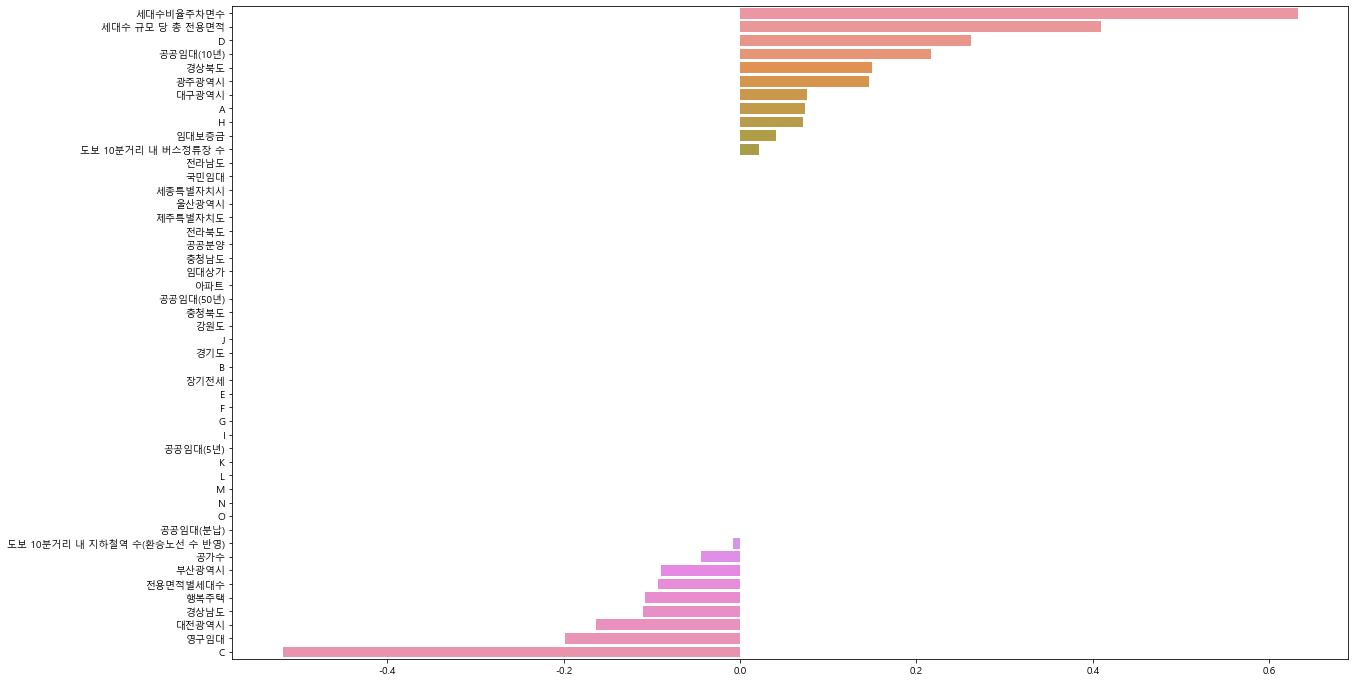

In [314]:
importance = lasso_grid.best_estimator_.coef_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [315]:
lasso_best = lasso_grid.best_estimator_


X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = lasso_best.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

15.029818109533474

### Ridge & Lasso & CatBoost 조합 -> 0.2 & 0.2 & 0.6 조합

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)

mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

Learning rate set to 0.04469
0:	learn: 1.7656341	total: 1.55ms	remaining: 1.55s
1:	learn: 1.6937963	total: 2.94ms	remaining: 1.47s
2:	learn: 1.6268762	total: 4.21ms	remaining: 1.4s
3:	learn: 1.5629090	total: 5.49ms	remaining: 1.37s
4:	learn: 1.4996258	total: 6.79ms	remaining: 1.35s
5:	learn: 1.4394607	total: 8.21ms	remaining: 1.36s
6:	learn: 1.3820867	total: 9.6ms	remaining: 1.36s
7:	learn: 1.3266440	total: 10.9ms	remaining: 1.35s
8:	learn: 1.2754214	total: 12.3ms	remaining: 1.36s
9:	learn: 1.2260013	total: 13.8ms	remaining: 1.37s
10:	learn: 1.1796912	total: 15.1ms	remaining: 1.36s
11:	learn: 1.1366496	total: 16.4ms	remaining: 1.35s
12:	learn: 1.0926045	total: 17.6ms	remaining: 1.34s
13:	learn: 1.0516589	total: 18.9ms	remaining: 1.33s
14:	learn: 1.0110154	total: 20.2ms	remaining: 1.33s
15:	learn: 0.9721038	total: 21.7ms	remaining: 1.33s
16:	learn: 0.9352537	total: 23ms	remaining: 1.33s
17:	learn: 0.9000343	total: 24.3ms	remaining: 1.33s
18:	learn: 0.8666014	total: 25.6ms	remaining: 1.3

269:	learn: 0.1862163	total: 334ms	remaining: 902ms
270:	learn: 0.1859979	total: 335ms	remaining: 901ms
271:	learn: 0.1857841	total: 336ms	remaining: 900ms
272:	learn: 0.1855115	total: 337ms	remaining: 899ms
273:	learn: 0.1854726	total: 339ms	remaining: 897ms
274:	learn: 0.1851651	total: 340ms	remaining: 896ms
275:	learn: 0.1850143	total: 341ms	remaining: 894ms
276:	learn: 0.1847889	total: 342ms	remaining: 893ms
277:	learn: 0.1845792	total: 343ms	remaining: 892ms
278:	learn: 0.1843771	total: 345ms	remaining: 891ms
279:	learn: 0.1841946	total: 346ms	remaining: 889ms
280:	learn: 0.1839898	total: 347ms	remaining: 888ms
281:	learn: 0.1834134	total: 348ms	remaining: 887ms
282:	learn: 0.1830220	total: 350ms	remaining: 885ms
283:	learn: 0.1826859	total: 351ms	remaining: 884ms
284:	learn: 0.1822682	total: 352ms	remaining: 883ms
285:	learn: 0.1822287	total: 353ms	remaining: 881ms
286:	learn: 0.1820246	total: 354ms	remaining: 880ms
287:	learn: 0.1819255	total: 355ms	remaining: 879ms
288:	learn: 

554:	learn: 0.1394693	total: 671ms	remaining: 538ms
555:	learn: 0.1393758	total: 672ms	remaining: 537ms
556:	learn: 0.1392860	total: 673ms	remaining: 535ms
557:	learn: 0.1391233	total: 674ms	remaining: 534ms
558:	learn: 0.1390195	total: 675ms	remaining: 533ms
559:	learn: 0.1388713	total: 677ms	remaining: 532ms
560:	learn: 0.1386640	total: 678ms	remaining: 531ms
561:	learn: 0.1385818	total: 679ms	remaining: 529ms
562:	learn: 0.1384513	total: 680ms	remaining: 528ms
563:	learn: 0.1383403	total: 682ms	remaining: 527ms
564:	learn: 0.1380814	total: 683ms	remaining: 526ms
565:	learn: 0.1379984	total: 684ms	remaining: 525ms
566:	learn: 0.1379303	total: 686ms	remaining: 524ms
567:	learn: 0.1377337	total: 687ms	remaining: 522ms
568:	learn: 0.1375263	total: 688ms	remaining: 521ms
569:	learn: 0.1373494	total: 690ms	remaining: 520ms
570:	learn: 0.1373079	total: 691ms	remaining: 519ms
571:	learn: 0.1372796	total: 692ms	remaining: 518ms
572:	learn: 0.1372088	total: 693ms	remaining: 517ms
573:	learn: 

831:	learn: 0.1112674	total: 1.01s	remaining: 203ms
832:	learn: 0.1111967	total: 1.01s	remaining: 202ms
833:	learn: 0.1111430	total: 1.01s	remaining: 201ms
834:	learn: 0.1110187	total: 1.01s	remaining: 200ms
835:	learn: 0.1109095	total: 1.01s	remaining: 199ms
836:	learn: 0.1108203	total: 1.01s	remaining: 197ms
837:	learn: 0.1107679	total: 1.01s	remaining: 196ms
838:	learn: 0.1106798	total: 1.01s	remaining: 195ms
839:	learn: 0.1105742	total: 1.02s	remaining: 194ms
840:	learn: 0.1104729	total: 1.02s	remaining: 193ms
841:	learn: 0.1103359	total: 1.02s	remaining: 191ms
842:	learn: 0.1103030	total: 1.02s	remaining: 190ms
843:	learn: 0.1102119	total: 1.02s	remaining: 189ms
844:	learn: 0.1101628	total: 1.02s	remaining: 188ms
845:	learn: 0.1100832	total: 1.02s	remaining: 186ms
846:	learn: 0.1099533	total: 1.02s	remaining: 185ms
847:	learn: 0.1098717	total: 1.03s	remaining: 184ms
848:	learn: 0.1097570	total: 1.03s	remaining: 183ms
849:	learn: 0.1097037	total: 1.03s	remaining: 182ms
850:	learn: 

10.84453996081989

In [320]:
# ridge(0.2) lasso(0.2) catboost(0.6) 조합 -> , MAE -> 10.8445

ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_df_log, y_train_df_log)
lasso_pred = lasso_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
sub_df.to_csv("ridge(0.2) & lasso(0.2)& catboost(0.6)조합_공급유형추가_임대보증금예측값적용_GBM_0728.csv", index=False)

sub_df

Learning rate set to 0.04704
0:	learn: 1.7677018	total: 1.58ms	remaining: 1.58s
1:	learn: 1.6933296	total: 3.08ms	remaining: 1.54s
2:	learn: 1.6217945	total: 4.52ms	remaining: 1.5s
3:	learn: 1.5529940	total: 6.06ms	remaining: 1.51s
4:	learn: 1.4870489	total: 7.66ms	remaining: 1.52s
5:	learn: 1.4237032	total: 9.14ms	remaining: 1.51s
6:	learn: 1.3638633	total: 10.6ms	remaining: 1.51s
7:	learn: 1.3091942	total: 11.6ms	remaining: 1.43s
8:	learn: 1.2559154	total: 13ms	remaining: 1.43s
9:	learn: 1.2065157	total: 14.4ms	remaining: 1.43s
10:	learn: 1.1569224	total: 15.9ms	remaining: 1.43s
11:	learn: 1.1104425	total: 17.3ms	remaining: 1.42s
12:	learn: 1.0685479	total: 18.4ms	remaining: 1.4s
13:	learn: 1.0264029	total: 19.8ms	remaining: 1.4s
14:	learn: 0.9860140	total: 21.2ms	remaining: 1.39s
15:	learn: 0.9470251	total: 22.5ms	remaining: 1.39s
16:	learn: 0.9111688	total: 24ms	remaining: 1.39s
17:	learn: 0.8773909	total: 25.4ms	remaining: 1.38s
18:	learn: 0.8428614	total: 26.8ms	remaining: 1.38s


250:	learn: 0.1944482	total: 332ms	remaining: 990ms
251:	learn: 0.1942921	total: 333ms	remaining: 988ms
252:	learn: 0.1939825	total: 334ms	remaining: 987ms
253:	learn: 0.1936396	total: 336ms	remaining: 985ms
254:	learn: 0.1933604	total: 337ms	remaining: 984ms
255:	learn: 0.1929381	total: 338ms	remaining: 983ms
256:	learn: 0.1925281	total: 339ms	remaining: 981ms
257:	learn: 0.1922712	total: 341ms	remaining: 980ms
258:	learn: 0.1920491	total: 342ms	remaining: 979ms
259:	learn: 0.1918316	total: 344ms	remaining: 978ms
260:	learn: 0.1915508	total: 345ms	remaining: 977ms
261:	learn: 0.1912237	total: 346ms	remaining: 976ms
262:	learn: 0.1909393	total: 348ms	remaining: 975ms
263:	learn: 0.1907089	total: 349ms	remaining: 973ms
264:	learn: 0.1904178	total: 350ms	remaining: 972ms
265:	learn: 0.1901034	total: 352ms	remaining: 970ms
266:	learn: 0.1900206	total: 353ms	remaining: 969ms
267:	learn: 0.1898020	total: 354ms	remaining: 967ms
268:	learn: 0.1896451	total: 355ms	remaining: 966ms
269:	learn: 

517:	learn: 0.1437314	total: 673ms	remaining: 626ms
518:	learn: 0.1436108	total: 674ms	remaining: 625ms
519:	learn: 0.1434826	total: 676ms	remaining: 624ms
520:	learn: 0.1431942	total: 677ms	remaining: 622ms
521:	learn: 0.1430162	total: 678ms	remaining: 621ms
522:	learn: 0.1429215	total: 680ms	remaining: 620ms
523:	learn: 0.1427908	total: 681ms	remaining: 618ms
524:	learn: 0.1427078	total: 682ms	remaining: 617ms
525:	learn: 0.1425828	total: 683ms	remaining: 616ms
526:	learn: 0.1424656	total: 685ms	remaining: 615ms
527:	learn: 0.1422570	total: 686ms	remaining: 613ms
528:	learn: 0.1421469	total: 687ms	remaining: 612ms
529:	learn: 0.1420363	total: 689ms	remaining: 611ms
530:	learn: 0.1419096	total: 690ms	remaining: 609ms
531:	learn: 0.1417402	total: 692ms	remaining: 608ms
532:	learn: 0.1416370	total: 693ms	remaining: 607ms
533:	learn: 0.1415615	total: 694ms	remaining: 606ms
534:	learn: 0.1413942	total: 696ms	remaining: 605ms
535:	learn: 0.1412855	total: 697ms	remaining: 603ms
536:	learn: 

769:	learn: 0.1155951	total: 1.01s	remaining: 301ms
770:	learn: 0.1155493	total: 1.01s	remaining: 300ms
771:	learn: 0.1154150	total: 1.01s	remaining: 299ms
772:	learn: 0.1152934	total: 1.01s	remaining: 297ms
773:	learn: 0.1152707	total: 1.01s	remaining: 296ms
774:	learn: 0.1151894	total: 1.01s	remaining: 295ms
775:	learn: 0.1150345	total: 1.02s	remaining: 293ms
776:	learn: 0.1149211	total: 1.02s	remaining: 292ms
777:	learn: 0.1147984	total: 1.02s	remaining: 291ms
778:	learn: 0.1147146	total: 1.02s	remaining: 289ms
779:	learn: 0.1146677	total: 1.02s	remaining: 288ms
780:	learn: 0.1146162	total: 1.02s	remaining: 287ms
781:	learn: 0.1145796	total: 1.02s	remaining: 286ms
782:	learn: 0.1145077	total: 1.02s	remaining: 284ms
783:	learn: 0.1143856	total: 1.03s	remaining: 283ms
784:	learn: 0.1142481	total: 1.03s	remaining: 282ms
785:	learn: 0.1141960	total: 1.03s	remaining: 280ms
786:	learn: 0.1141217	total: 1.03s	remaining: 279ms
787:	learn: 0.1140041	total: 1.03s	remaining: 278ms
788:	learn: 

,code,num
0,C1072,706.115105
1,C1128,1320.104761
2,C1456,439.258810
3,C1840,458.373613
4,C1332,1161.306474
...,...,...
145,C2456,240.622396
146,C1266,424.822716
147,C2152,25.859869
148,C1267,337.383454


In [ ]:
# params = {'iterations': np.random.randint(100, 1000, size=10),
#           'depth': np.random.randint(1, 15, size=10),
#           'learning_rate': np.random.rand(10, 1).reshape(-1),
#           'l2_leaf_reg': np.random.randint(1, 30, size=5)}

# cat_reg = CatBoostRegressor(random_seed=42),
# grid_model = GridSearchCV(cat_reg, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
# grid_model.fit(X_train_df_log, y_train_df_log)